In [256]:
!pip install imutils
!pip install pytesseract

In [784]:
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import imutils
from scipy.signal import find_peaks
from skimage.segmentation import clear_border

from PIL import Image
from pytesseract import pytesseract

from tqdm import tqdm
import re

pytesseract.tesseract_cmd = r'C:\Users\knob\AppData\Local\Tesseract-OCR\tesseract.exe'

# Manuscript Excel

In [921]:
file_name = 'CONC.xlsx'
df_MN = pd.read_excel(file_name, usecols="A:C" )

In [922]:
def verify_integrity(df):
    id_list = list(range(len(df)+1))

    def verify_unicity(val):
        try:
            id_list.remove(val)
            
        except:
            print(f'Error : id = {val} ')            
            
    df['Classement'].apply(verify_unicity)
    print(id_list)
    
            
            
verify_integrity(df_MN) 
# 256 239 116 487
    

[0]


# Computer Vision analysis

### Extract the raw images

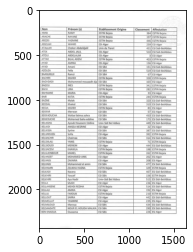

In [8]:
repository = './concours/'
file_name_format = 'Concours 2022 MI-{:02d}.png'
nb_pages = 11

raw_img_array = []
for i in range(11):
    path = repository + file_name_format.format(i+1)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img[:,:,0] = img[:, :, 2]
    img[:,:,1] = img[:, :, 2]
    raw_img_array.append(img)
plt.imshow(raw_img_array[1])

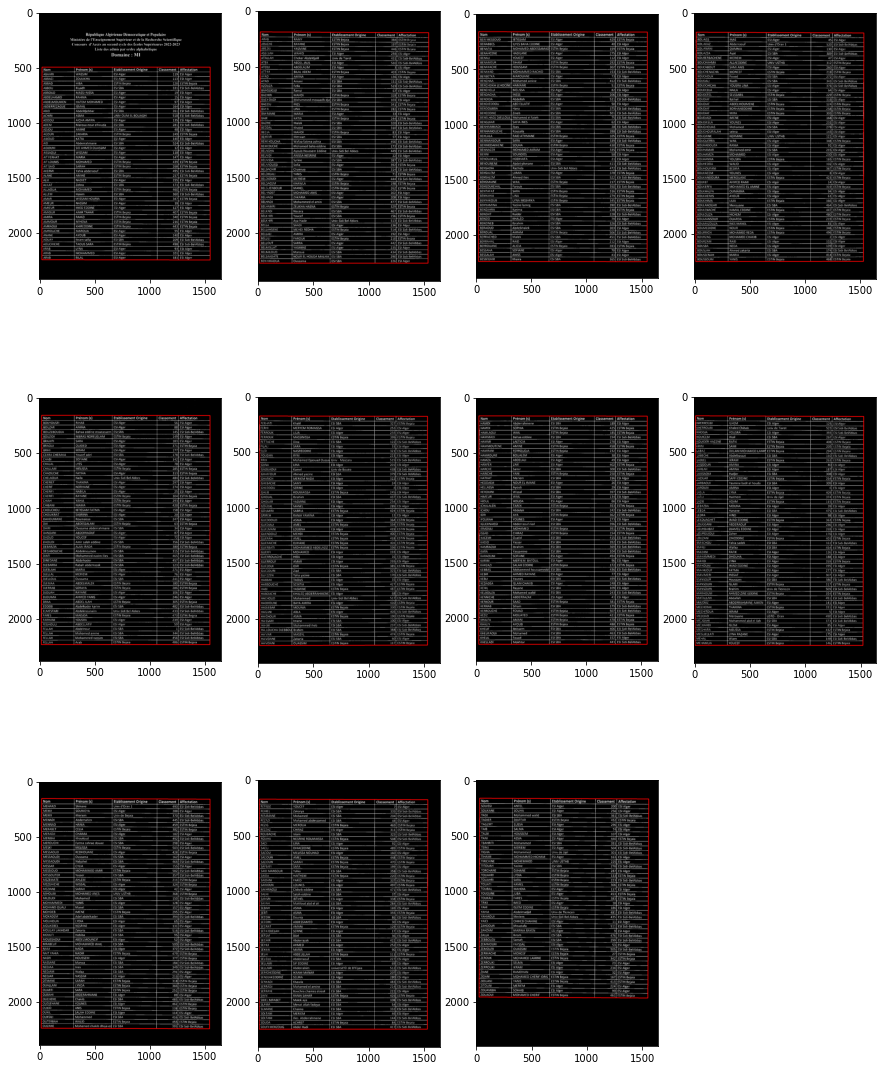

In [324]:
plt.figure(figsize=(15, 20))

warped_img_array = []

for idx, img in enumerate(raw_img_array):
    
    #Gray Scaling and Thresholing--------------------------------
    imgray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

    ret,thresh = cv2.threshold(imgray,127,255,0)
    thresh = cv2.bitwise_not(thresh)
    
    
    #Finding the contours---------------------------------------
    items = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(items)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    
    #Extracting the Contours each Table -------------------------
    tableContour = None
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)
        
        if len(approx) == 4:
            tableContour = approx
            break
            
    tableContour = tableContour.reshape(-1, 4, 2)
    
    #Warping each image according to the contours---------------
    
    order_point(tableContour.reshape(4, 2))

    warped = four_point_transform(imgray, tableContour.reshape(4, 2))
    
    warped_img_array.append(warped)
    
    #Ploting--------------------------------------------------
    plt.subplot(3, 4, idx+1)
    backtorgb = cv2.cvtColor(thresh,cv2.COLOR_GRAY2RGB)
    cv2.drawContours(backtorgb, tableContour, -1, (255, 0, 0), 5)
    plt.imshow(backtorgb)
    

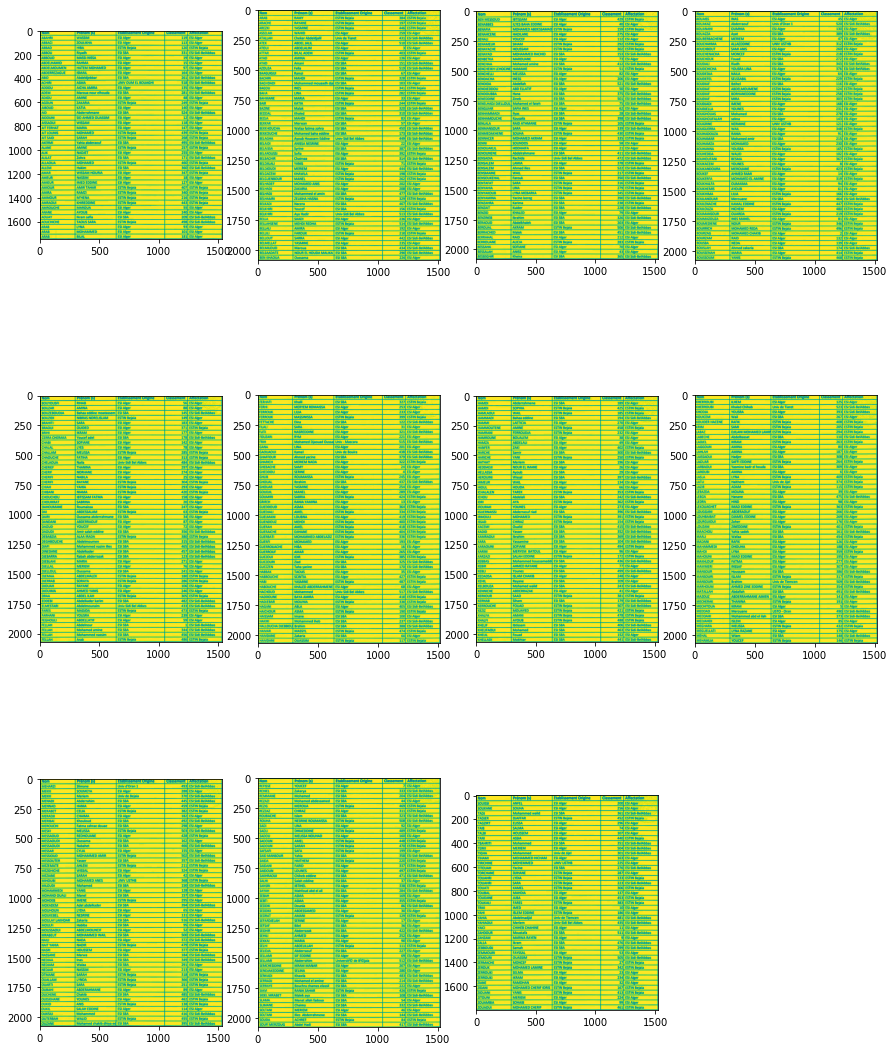

In [325]:
plt.figure(figsize=(15, 20))

for idx, warped in enumerate(warped_img_array):
    plt.subplot(3, 4, idx+1)
    plt.imshow(warped)

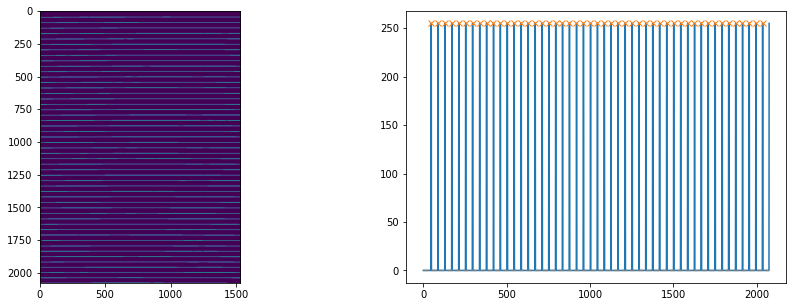

In [765]:
def compute_row_interval_pixel(warped_img_array, show=False):
    peaks_tab = []
    
    for idx, warped in enumerate(warped_img_array):
        horizantal = np.copy(warped)
        horizantal = horizantal[2:-2,:]
        
        ret,horizantal = cv2.threshold(horizantal,127,255,0)
        horizantal = cv2.bitwise_not(horizantal)

        horizantalsize = horizantal.shape[1]//30
        horizantalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizantalsize, 1))
        horizantal = cv2.erode(horizantal, horizantalStructure)
        horizantal = cv2.dilate(horizantal, horizantalStructure)
        
        vector = horizantal[:, horizantalsize//2]
        peaks, _ = find_peaks(vector, prominence=1)
        
        if idx == 2 and show:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(horizantal)
            plt.subplot(1, 2, 2)
            plt.plot(vector)
            plt.plot(peaks, vector[peaks], "x")
            plt.plot(np.zeros_like(vector), "--", color="gray")   
            
        peaks = np.append(peaks, horizantal.shape[0]) #We will need this later when generating the rows
        peaks_tab.append(peaks)
    
    return peaks_tab

ROWS_INTERVALS = compute_row_interval_pixel(warped_img_array, show=True)

In [766]:
ROWS_INTERVALS[2]

array([  47,   88,  130,  172,  213,  254,  296,  338,  380,  421,  462,
        504,  545,  587,  629,  671,  713,  753,  794,  835,  877,  919,
        961, 1003, 1045, 1086, 1126, 1168, 1211, 1253, 1294, 1335, 1377,
       1418, 1460, 1502, 1544, 1586, 1627, 1668, 1709, 1751, 1793, 1833,
       1874, 1915, 1955, 1995, 2036, 2076], dtype=int64)

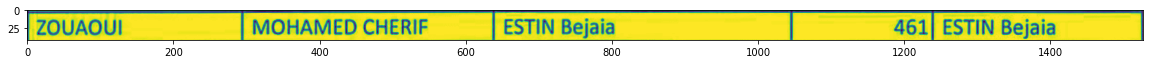

In [767]:
def get_row_list(img_array):
    row_list = []

    for idx, warped in enumerate(warped_img_array):
        nb_row = warped.shape[0] / ROW_HEIGHTS[idx]
        nb_row = len(ROWS_INTERVALS[idx])#int(round(nb_row))
        
        for i in range(nb_row-1):
            #if i == 0: continue         #We remove the header row
            if i > nb_row: continue
            
            #dec = 5             #Au pif
            #begin = int(round((ROW_HEIGHTS[idx] + dec)*i ))
            begin = ROWS_INTERVALS[idx][i]
            end = ROWS_INTERVALS[idx][i+1]
            
            current_row = warped[begin:end, :]
            row_list.append(current_row)
            plt.imshow(current_row)
            
            begin = round(end + 0)

    return row_list
plt.figure(figsize=(20, 25))
row_list = get_row_list(warped_img_array)

524


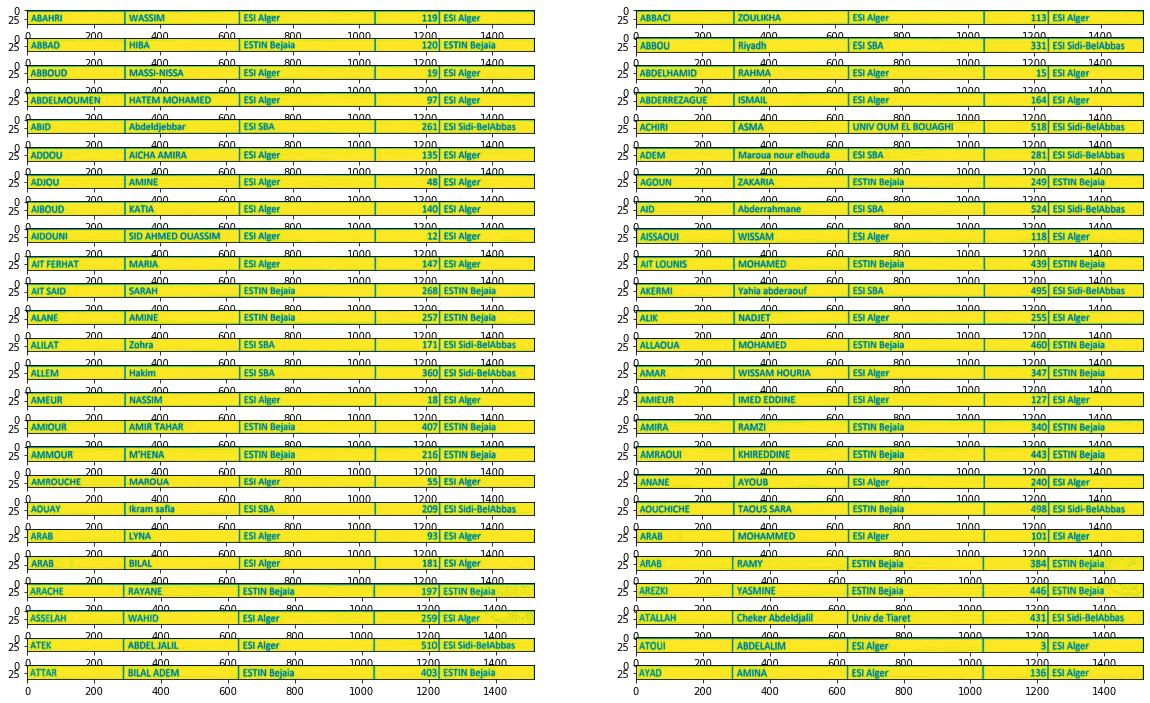

In [779]:
print(len(row_list))
plt.figure(figsize=(20, 25))
for i in range(50):
    plt.subplot(50, 2, i+1)
    plt.imshow(row_list[i])
    

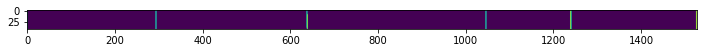

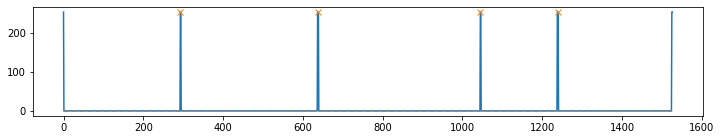

In [739]:
def compute_cell_interval_pixel(row_list):
    vertical = np.copy(row_list[0])
    ret,vertical = cv2.threshold(vertical,127,255,0)
    vertical = cv2.bitwise_not(vertical)
    verticalsize = vertical.shape[0]
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
    vertical = cv2.erode(vertical, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)
    plt.figure(figsize=(12, 2))
    plt.imshow(vertical)
    plt.show()
    plt.figure(figsize=(12, 2))
    vector = vertical[verticalsize//2, :]
    peaks, _ = find_peaks(vector, prominence=1)
    plt.plot(vector)
    plt.plot(peaks, vector[peaks], "x")
    plt.plot(np.zeros_like(vector), "--", color="gray")    

    return peaks
CELL_INTERVALS = compute_cell_interval_pixel(row_list)

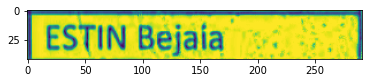

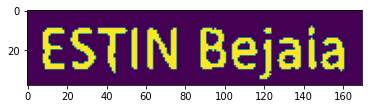

In [909]:
def remove_bordernoise_from_cell(cell, idx=-1):
    
    _, thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_OTSU| cv2.THRESH_BINARY_INV)
    thresh = clear_border(thresh)
    #kernel = np.ones((2,2),np.uint8)
    #thresh = cv2.erode(thresh,kernel,iterations = 1)
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
    dilation = cv2.dilate(thresh, rect_kernel, iterations = 1)
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    try:
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped = thresh[y:y + h, x:x + w]
        return cropped
    
    except:
        print(idx)
        plt.imshow(cell)
        raise 

plt.imshow(cells_list[287]['affectation'])
plt.show()
plt.imshow(remove_bordernoise_from_cell(cells_list[287]['affectation']))

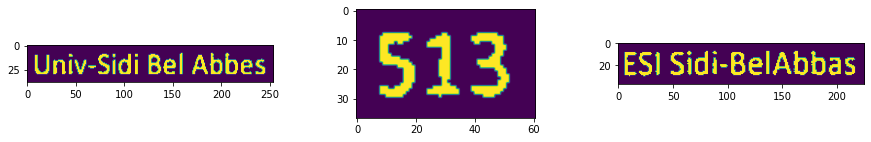

In [911]:
def extract_cells(row_list):
    cells_list = []
    
    for idx, row in enumerate(row_list):
                
        origine = row[ : , CELL_INTERVALS[1] : CELL_INTERVALS[2] ]
        classement = row[ : , CELL_INTERVALS[2] : CELL_INTERVALS[3] ]
        affectation = row[ : , CELL_INTERVALS[3] : ]
        
        origine = remove_bordernoise_from_cell(origine, idx)
        classement = remove_bordernoise_from_cell(classement, idx)
        affectation = remove_bordernoise_from_cell(affectation, idx)
        
        cells = {
            "origine": origine, 
            "classement": classement, 
            "affectation": affectation
        }
        
        cells_list.append(cells)
        
    return cells_list

cells_list = extract_cells(row_list)
    
plt.figure(figsize=(15, 2))
plt.subplot(1, 3, 1)
plt.imshow(cells_list[80]['origine'])
plt.subplot(1, 3, 2)
plt.imshow(cells_list[80]['classement'])
plt.subplot(1, 3, 3)
plt.imshow(cells_list[80]['affectation'])

In [912]:
config1 = '--psm 13 -c tessedit_char_whitelist="abcdefghijklmnopqrstuvwyzABCDEFGHIJKLMNOPQRSTUVWXYZ- "'
config2 = '--psm 13 -c tessedit_char_whitelist=0123456789'
config3 = '--psm 13 -c tessedit_char_whitelist="ESIABSTINsid-belaegrj "'
def get_text_from_cells(cells_list):
    text_cells_list = []
    
    for idx, row in tqdm(enumerate(cells_list)):
        origine = Image.fromarray(row['origine'])
        classement = Image.fromarray(row['classement'])
        affectation = Image.fromarray(row['affectation'])
        
        origine_text = pytesseract.image_to_string(origine, config=config1)
        classement_text = pytesseract.image_to_string(classement, config=config2)
        affectation_text = pytesseract.image_to_string(affectation, config=config3)
        
        text_cells_list.append({
            "origine": origine_text,
            "classement": classement_text,
            "affectation": affectation_text
        })
        
        
    return text_cells_list

text_cells_list = get_text_from_cells(cells_list)


524it [05:11,  1.68it/s]


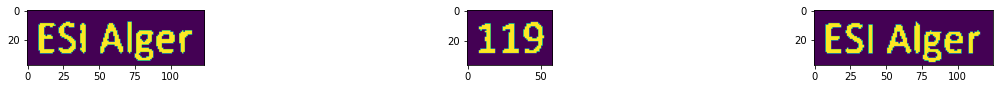

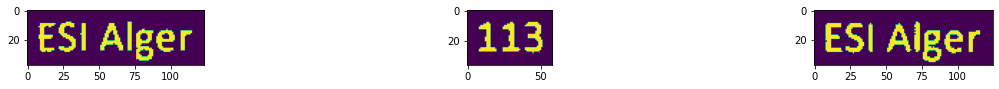

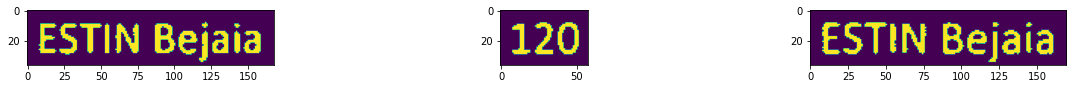

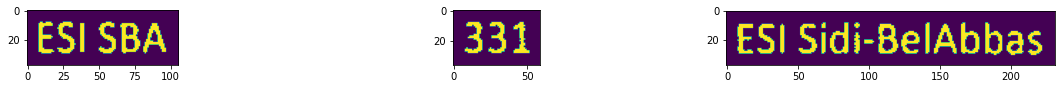

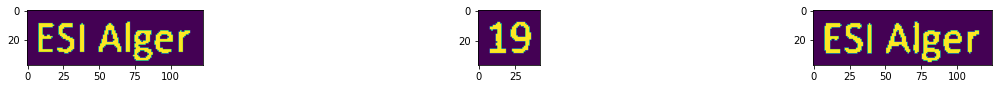

In [913]:
for i in range(5):
    plt.figure(figsize=(20, 1))
    plt.subplot(1, 3, 1)
    plt.imshow(cells_list[i]['origine'])
    plt.subplot(1, 3, 2)
    plt.imshow(cells_list[i]['classement'])
    plt.subplot(1, 3, 3)
    plt.imshow(cells_list[i]['affectation'])

In [914]:
text_cells_list[:10]


[{'origine': 'ESI Alger\n',
  'classement': '119\n',
  'affectation': 'ESI Alger\n'},
 {'origine': 'S Alger\n', 'classement': '113\n', 'affectation': 'ESI Alger\n'},
 {'origine': 'ESTIN Bejaia\n',
  'classement': '120\n',
  'affectation': 'ESTIN Bejaia\n'},
 {'origine': 'ESI SBA\n',
  'classement': '331\n',
  'affectation': 'SI Sidi-BelAbbas\n'},
 {'origine': 'ESI Alger\n',
  'classement': '19\n',
  'affectation': 'ESI Alger\n'},
 {'origine': 'ESI Alger\n',
  'classement': '45\n',
  'affectation': 'ESI Alger\n'},
 {'origine': 'ESI Alger\n',
  'classement': '97\n',
  'affectation': 'ESI Alger\n'},
 {'origine': 'ESI Alger\n',
  'classement': '164\n',
  'affectation': 'ESI Alger\n'},
 {'origine': 'ESI SBA\n',
  'classement': '261\n',
  'affectation': 'ESI Sidi-BelAbbas\n'},
 {'origine': 'UNIV OUM EL BOUAGHI\n',
  'classement': '518\n',
  'affectation': 'ESi Sidi-BelAbbas\n'}]

In [915]:
text_dict = {
    "origine" : [],
    "classement": [],
    "affectation": []
}
plt.figure(figsize=(20, 2))
i = 1
for idx, line in enumerate(text_cells_list):
    
    #Classement----------------------------------------------
    text_dict['classement'].append( int(line['classement']) )
   
    #Origine----------------------------------------------
    if re.search('(UNIV|Univ|USTO)', line['origine']) != None:
        text_dict['origine'].append( 'U' )
        
    elif re.search('(ESTIN|Bejaia)', line['origine']) != None:
        text_dict['origine'].append( 'B' )
        
    elif re.search('(Sidi|BelAbbas|SBA)', line['origine']) != None:
        text_dict['origine'].append( 'S' )
        
    elif re.search('(Alger|ESI|er)', line['origine']) != None:
        text_dict['origine'].append( 'A' )
        
    else:
        print( line['origine']  )
    
    #Affectation----------------------------------------------
        
    if re.search('(ESTIN|Bejaia)', line['affectation']) != None:
        text_dict['affectation'].append( 'B' )
        
    elif re.search('(SBA|BelAbbas)', line['affectation']) != None:
        text_dict['affectation'].append( 'S' )
        
    elif re.search('(Alger|ESI)', line['affectation']) != None:
        text_dict['affectation'].append( 'A' )
        
    else:
        print(line['affectation'])
        plt.subplot(10, 1, i); i+= 1
        plt.imshow(row_list[idx])
        text_dict['affectation'].append( 'A' )#Dans le doute
        #print(line['affectation'])

    

<Figure size 1440x144 with 0 Axes>

In [916]:
len(text_dict['origine'])

524

In [923]:
df_AI = pd.DataFrame.from_dict(text_dict)
df_AI.to_excel('results.xlsx', header=True, index=False)

# Comparison

In [924]:
print("Model precision:")
(df_MN['Classement'] == df_AI['classement']).value_counts()

Model precision:


True     510
False     14
dtype: int64

In [925]:
(df_MN['Origine'].apply(lambda x: x[:1]) == df_AI['origine']).value_counts()

True    524
dtype: int64

In [926]:
(df_MN['Affectation'] == df_AI['affectation']).value_counts()

True    524
dtype: int64

In [927]:
df_AI['origine'][(df_MN['Affectation'] == df_AI['affectation']) == False]

Series([], Name: origine, dtype: object)

In [928]:
df_AI['origine'][(df_MN['Origine'].apply(lambda x: x[:1]) == df_AI['origine']) == False]

Series([], Name: origine, dtype: object)

In [929]:
df_MN['Origine'][(df_MN['Origine'].apply(lambda x: x[:1]) == df_AI['origine']) == False]

Series([], Name: Origine, dtype: object)

# UTILS

In [4]:
def order_point(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    
    return rect

def four_point_transform(image, pts):

    (tl, tr, br, bl) = rect = order_point(pts)

    width_top = np.sqrt((tl[0] - tr[0])**2 + (tl[1] - tr[1])**2)
    width_bottom = np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2)

    #Le width de l'image final va etre le max entre le width du coté du haut
    #et du coté du bas, (le int() sert à transformer la matrice numpy en integer)
    width_image_final = max(int(width_bottom), int(width_top))

    height_left = np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2)
    height_right = np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2)

    #De memepour le height
    height_image_final = max(int(height_left), int(height_right))


    #On crée ensuite la matrice qui va encoder notre y transformation 

    tr = np.array([
        [0, 0],
        [width_image_final -1, 0],
        [width_image_final -1, height_image_final-1],
        [0, height_image_final-1]
    ], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, tr)

    new_img = cv2.warpPerspective(image, M, (width_image_final, height_image_final))

    return new_img

In [5]:
def compute_vertical_autocorr(img):
    rows, cols = warped.shape
    x_arr = []
    for n in range(cols):
        x_arr_n = 0
        for k in range(cols-n):
            x_arr_n += np.multiply(img[k, :], img[ n + k, :]).sum()
        x_arr.append(x_arr_n/cols)
        
    return np.array(x_arr)

def compute_cell_pixel_height(peaks):
    mean = 0
    for i in reversed(range(1, len(peaks))):
        mean += peaks[i] - peaks[i-1]
    
    return mean/len(peaks)

# Failed Tests

## Rows detection using Autocorrelation

40.21621621621622

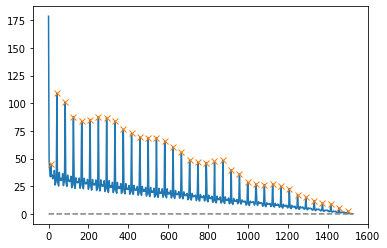

In [625]:
#Every image page here has the same row height, so we shall compute it once
MIN_PIXEL_DIST = 30

def get_row_height(page=0, show=False):
    warped = warped_img_array[page]
    ret,thresh = cv2.threshold(warped,127,255,0)
    thresh = cv2.bitwise_not(thresh)
    x_warped = compute_vertical_autocorr(thresh)
    peaks, _ = find_peaks(x_warped, distance = MIN_PIXEL_DIST)
    ROW_HEIGHT = compute_cell_pixel_height(peaks)
    
    if show:
        plt.plot(x_warped)
        plt.plot(peaks, x_warped[peaks], "x")
        plt.plot(np.zeros_like(x_warped), "--", color="gray")
    
    return ROW_HEIGHT

get_row_height(page=3, show=True)
ROW_HEIGHTS = [get_row_height(page=idx) for idx in range(11)]